#Naive Bayes - Classification Model using defence dataset (Soldiers safety evaluation)

#Import the libraries

In [ ]:
# ============================
# Naive Bayes (fixed manual input) - Soldier Safety
# ============================
!pip install -q ipywidgets plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets
from IPython.display import display, clear_output



In [ ]:
# -----------------------------
# 1) Load & normalize dataset
# -----------------------------
df = pd.read_csv("/content/soldier_safety.csv")   # ensure this file is in Colab working dir
# normalize textual categories to lowercase + strip
cat_columns = ['helmet_worn', 'bulletproof_vest', 'communication_device', 'terrain', 'safety_status']
for c in cat_columns:
    df[c] = df[c].astype(str).str.lower().str.strip()

print("Sample rows after normalization:")
display(df.head())



Sample rows after normalization:


,helmet_worn,bulletproof_vest,communication_device,night_patrol_hours,terrain,safety_status
0,1,0,1,11,urban,safe
1,1,0,1,4,urban,risky
2,0,1,1,9,mountain,risky
3,0,1,1,3,mountain,safe
4,1,1,1,1,mountain,risky


#Label Encoder for cat features

In [ ]:
# -----------------------------
# 2) Build per-column encoders + mappings (store them)
# -----------------------------
encoders = {}
for c in cat_columns:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    # mapping from label string -> encoded int
    mapping = {cls: int(le.transform([cls])[0]) for cls in le.classes_}
    encoders[c] = {"le": le, "classes": list(le.classes_), "mapping": mapping}
    print(f"Column: {c}  classes: {encoders[c]['classes']}  mapping: {encoders[c]['mapping']}")



Column: helmet_worn  classes: ['0', '1']  mapping: {'0': 0, '1': 1}
Column: bulletproof_vest  classes: ['0', '1']  mapping: {'0': 0, '1': 1}
Column: communication_device  classes: ['0', '1']  mapping: {'0': 0, '1': 1}
Column: terrain  classes: ['forest', 'mountain', 'plains', 'urban']  mapping: {'forest': 0, 'mountain': 1, 'plains': 2, 'urban': 3}
Column: safety_status  classes: ['risky', 'safe']  mapping: {'risky': 0, 'safe': 1}


#Split the dataset and scaling the features

In [ ]:
# -----------------------------
# 3) Prepare features & target
# -----------------------------
target_col = "safety_status"
feature_cols = [c for c in df.columns if c != target_col]
X = df[feature_cols]
y = df[target_col]

# Scale numeric features (safe because some "categorical" are encoded ints — that's OK for NB)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Exploratory Data Analysis


Class distribution (encoded):


,count
safety_status,
0,216
1,184


Target mapping (encoded -> label):
0 <--> risky
1 <--> safe


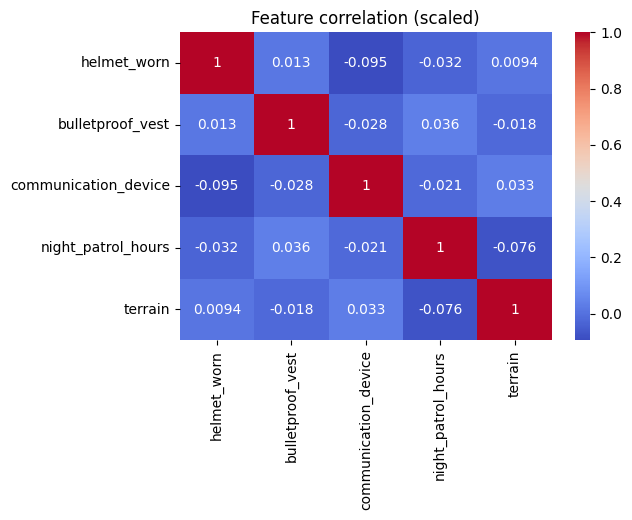

In [ ]:
# -----------------------------
# 4) EDA - class balance and correlation
# -----------------------------
print("\nClass distribution (encoded):")
display(y.value_counts())

# Show class names mapping for readability
print("Target mapping (encoded -> label):")
t_le = encoders[target_col]["le"]
for i,cls in enumerate(t_le.classes_):
    print(i, "<-->", cls)

plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), annot=True, cmap="coolwarm")
plt.title("Feature correlation (scaled)")
plt.show()



#Train the model and find the best hyperparameters

***var smoothing***

1. In general, smoothing function never makes function to return 0 instead it'll add some small constant (α) to the counts so that nothing is ever exactly zero.

2. This is called Laplace smoothing (if α=1) or additive smoothing.



Scenario:

Suppose you classify emails as spam / ham.

Word “bitcoin” appears only in spam, never in ham.

Without smoothing:

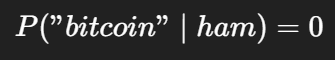


→ model will always predict spam if “bitcoin” is present.

With smoothing:

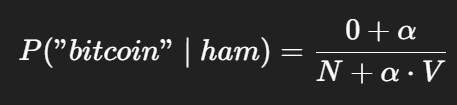


→ a very small probability, but not zero.

In [ ]:
# -----------------------------
# 5) Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25,
                                                    random_state=42, stratify=y)

# -----------------------------
# 6) Train Naive Bayes and hyperparameter scan (var_smoothing)
# -----------------------------
smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6]
results = []
for s in smoothing_values:
    model = GaussianNB(var_smoothing=s)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results.append((s, acc))
print("\nVar_smoothing results:")
for s,acc in results:
    print(f"var_smoothing={s:.0e} -> accuracy={acc:.4f}")

# choose best smoothing value
best_s = max(results, key=lambda r: r[1])[0]
nb_model = GaussianNB(var_smoothing=best_s)
nb_model.fit(X_train, y_train)




Var_smoothing results:
var_smoothing=1e-09 -> accuracy=0.5900
var_smoothing=1e-08 -> accuracy=0.5900
var_smoothing=1e-07 -> accuracy=0.5900
var_smoothing=1e-06 -> accuracy=0.5900


GaussianNB()

#Evaluating the model


Test accuracy: 0.59

Classification report:
              precision    recall  f1-score   support

       risky       0.58      0.87      0.70        54
        safe       0.63      0.26      0.37        46

    accuracy                           0.59       100
   macro avg       0.61      0.57      0.53       100
weighted avg       0.60      0.59      0.55       100



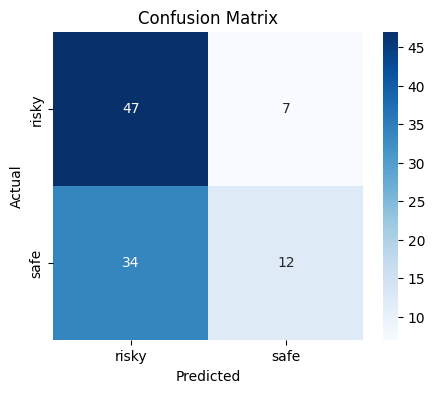

In [ ]:
# -----------------------------
# 7) Evaluate final model
# -----------------------------
y_pred = nb_model.predict(X_test)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=t_le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=t_le.classes_, yticklabels=t_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



# Manual Validation (Not to focus much - Just for reference)

In [ ]:
# -----------------------------
# 8) Robust manual prediction helper (uses mappings)
# -----------------------------
def manual_predict(helmet, vest, comm, night_hours, terrain):
    """helmet/vest/comm/terrain expected as strings that match training classes (lowercase)"""
    try:
        # normalize inputs
        helmet = str(helmet).lower().strip()
        vest = str(vest).lower().strip()
        comm = str(comm).lower().strip()
        terrain = str(terrain).lower().strip()
        # map each categorical input using mapping dict; raise helpful error if unknown
        sample = {}
        for col, val in [("helmet_worn", helmet),
                         ("bulletproof_vest", vest),
                         ("communication_device", comm),
                         ("terrain", terrain)]:
            mapping = encoders[col]["mapping"]
            if val not in mapping:
                raise ValueError(f"Unknown value '{val}' for '{col}'. Allowed: {encoders[col]['classes']}")
            sample[col] = mapping[val]
        # night hours -> numeric
        sample["night_patrol_hours"] = float(night_hours)
        # create df in proper column order
        sample_df = pd.DataFrame([sample], columns=feature_cols)
        # scale
        sample_scaled = scaler.transform(sample_df)
        pred = nb_model.predict(sample_scaled)[0]
        proba = nb_model.predict_proba(sample_scaled)[0]
        label = t_le.inverse_transform([pred])[0]
        # pretty print with confidence
        print("Prediction ->", label.upper())
        # print class probabilities with readable order
        prob_dict = {t_le.classes_[i]: float(proba[i]) for i in range(len(proba))}
        print("Probabilities:", {k: f"{v*100:.1f}%" for k,v in prob_dict.items()})
    except Exception as ex:
        print("ERROR in manual_predict:", ex)

# quick manual test using valid training values:
print("\nExample manual tests (must use allowed categorical values):")
print("Allowed values examples per column:")
for c in ['helmet_worn','bulletproof_vest','communication_device','terrain']:
    print(f"  {c} -> {encoders[c]['classes']}")

# Example (replace these values with ones from your dataset's allowed lists)
manual_predict(helmet='yes', vest='yes', comm='no', night_hours=3, terrain='mountain')

# -----------------------------
# 9) Interactive widgets (populated from encoder classes so users can't pick invalid strings)
# -----------------------------
helmet_widget = widgets.Dropdown(options=encoders['helmet_worn']['classes'], description="Helmet:")
vest_widget   = widgets.Dropdown(options=encoders['bulletproof_vest']['classes'], description="Vest:")
comm_widget   = widgets.Dropdown(options=encoders['communication_device']['classes'], description="Comm:")
terrain_widget= widgets.Dropdown(options=encoders['terrain']['classes'], description="Terrain:")
night_slider  = widgets.IntSlider(min=0, max=12, step=1, value=3, description="Night hrs:")

out = widgets.Output()
def on_change(_=None):
    with out:
        clear_output(wait=True)
        manual_predict(
            helmet_widget.value,
            vest_widget.value,
            comm_widget.value,
            night_slider.value,
            terrain_widget.value
        )

# attach handlers
helmet_widget.observe(on_change, names='value')
vest_widget.observe(on_change, names='value')
comm_widget.observe(on_change, names='value')
terrain_widget.observe(on_change, names='value')
night_slider.observe(on_change, names='value')

display(widgets.VBox([helmet_widget, vest_widget, comm_widget, terrain_widget, night_slider]))
display(out)

# trigger initial display
on_change()



Example manual tests (must use allowed categorical values):
Allowed values examples per column:
  helmet_worn -> ['0', '1']
  bulletproof_vest -> ['0', '1']
  communication_device -> ['0', '1']
  terrain -> ['forest', 'mountain', 'plains', 'urban']
ERROR in manual_predict: Unknown value 'yes' for 'helmet_worn'. Allowed: ['0', '1']


Output()